# Tutorial: Source extraction with the SEP package

<br>
<br>

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 

**Author(s):** Kristin Anett Remmelgas

**Last modified:** 14.03.2025

**Notebook summary**

This example notebook presents a simple example use case for extracting sources from a Euclid image with the Python [SEP package](https://sep.readthedocs.io/en/stable/) (Python library for Source Extraction and Photometry) and making cutouts for those sources. In this case the sources we want to make cutouts from are all on the same image and we have the image available in ESA Datalabs in the Q1 data volume. The sources are extracted with SEP and cutouts are made with the [Astropy](https://docs.astropy.org/en/stable/index.html) function Cutout2D. We also provide an example how to overlay sources from the MER catalogue on the same image area as a comparison. The steps are:

* Step 1 Taking a look at the example image
* Step 2 Extracting sources from a part of the image with the SEP package that is based on Source Extractor
* Step 3 Overlaying MER catalogue sources on the image as comparison
* Step 4 Making a cutout of one source
* Step 5 Making a cutout of the full list of sources automatically
* Extra: Converting FITS file cutouts to jpgs

**Useful links:**

* [Q1 data release homepage](https://www.cosmos.esa.int/en/web/euclid/euclid-q1-data-release)
* [Euclid Q1 data product description](https://euclid.esac.esa.int/dr/q1/dpdd/index.html)
* [Euclid Astroquery documentation](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html)
* [SEP package documentation](https://sep.readthedocs.io/en/stable/)
* [Astropy function Cutout2D documentation](https://docs.astropy.org/en/stable/api/astropy.nddata.Cutout2D.html)


**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

**Importing necessary packages**

In [1]:
from astroquery.esa.euclid.core import EuclidClass
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy import wcs
from astropy.io import fits
from PIL import Image
import numpy as np
import sep
import glob
import os
import sys
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.text import Text
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)

**Logging in**

The following cell (and all other example notebooks) use a credential file for logging in to the archive. Create a cred.txt file in the folder my_workspace (only you have access to that folder) with 2 lines - one for your username and the other for your password. By doing this you can run all the example notebooks without changing anything.

There is also an example of an alternative login method where you put in you username and the cell asks for a password when you run it.

In [2]:
#choosing the archive envionment
Euclid = EuclidClass(environment='PDR')

# loggin in using a credential file
Euclid.login(credentials_file = '/media/user/cred.txt')

# logging in without the credential file
# Euclid.login(user='yourusername')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: Euclid TAP server url: eas.esac.esa.int:443/tap-server/tap/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: Euclid data server url: eas.esac.esa.int:443/sas-dd/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: Euclid cutout server url: eas.esac.esa.int:443/sas-cutout/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


**Creating a folder to save all our future cutouts to**

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace:`'/media/user/example_notebook_outputs/'`

In [3]:
#make a folder for the future cutouts
output_folder = '/media/user/example_notebook_outputs/'
cutout_folder = output_folder + 'cutouts/'
if not os.path.exists(cutout_folder):
    os.makedirs(cutout_folder)

## Step 1. Taking a look at the example image

When displaying the image we can combine Matplotlib imshow with astropy.visualization functions for image stretching and normalization. In the cell below we are using ZScaleInterval() and SquaredStretch(). ZScaleInterval() is an implementation of IRAF's ZScale Algorithm. According to the IRAF's documentation, the algorithm was designed to display the image values near the median image value without the time-consuming process of computing a full image histogram. Astropy.visualization also provides a list of other options for normalization and stretching functions. If you are interested in more examples, then here is some great [Astropy documentation](https://docs.astropy.org/en/stable/visualization/normalization.html#intervals-and-normalization) on the topic.

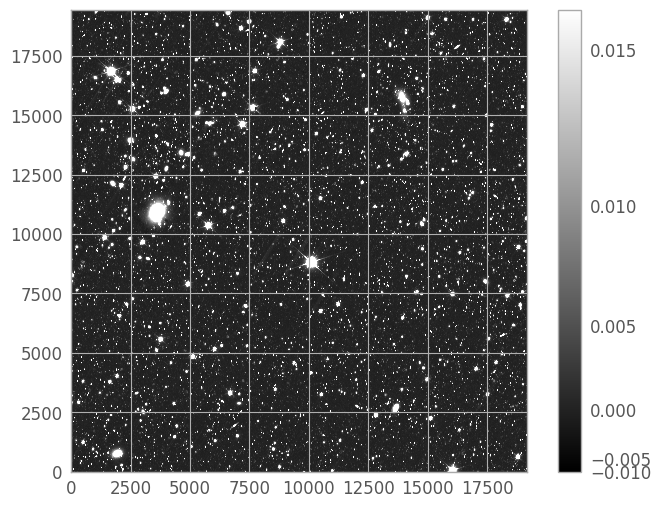

In [4]:
#plotting the full downloaded file
file_path = '/data/euclid_q1/Q1_R1/MER/102158889/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits'
hdul = fits.open(file_path)
image_data_big = hdul[0].data
header = hdul[0].header

plt.figure()
plt.imshow(image_data_big, cmap='gray', origin='lower', norm=ImageNormalize(image_data_big, interval=ZScaleInterval(), stretch=SquaredStretch()))
plt.colorbar();

## Step 2. Extracting sources from a part of the image with the sep python package

Since extracting the sources from the full image is computationally very heavy then from now on we will be working with a representative smaller part of the image (that has been selected to have a variety of different sources). For performing source extraction on the image we use a Python library for Source Extraction and Photometry - SEP. SEP makes the core algorithms of Source Extractor (Bertin & Arnouts 1996) available as a library of stand-alone functions and classes. A tutorial for using sep for source extraction can be found here: https://sep.readthedocs.io/en/v1.0.x/tutorial.html

In [5]:
#defining smaller area
small_data = (image_data_big[12700:14200, 13300:14800]).byteswap().newbyteorder()

#background subtraction
c_contiguous_data = np.ascontiguousarray(small_data)
bkg = sep.Background(c_contiguous_data)
data_sub = c_contiguous_data - bkg

#source extraction
sources = sep.extract(data_sub, 1.5, err=bkg.globalrms, minarea=200, deblend_cont=1.0)
sources_thr = sources[sources['flux'] > 50]
print("Found", len(sources_thr), "objects above flux threshold")

Found 20 objects above flux threshold


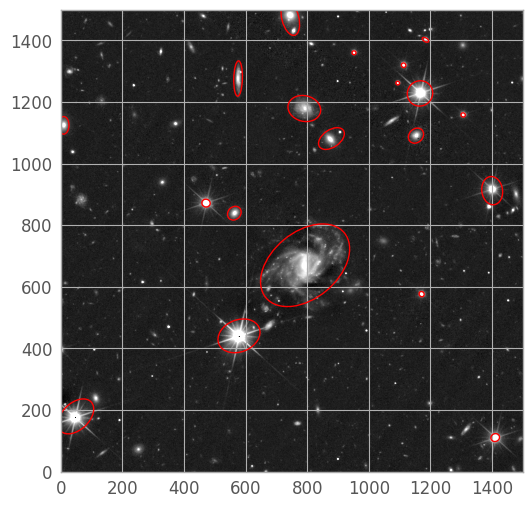

In [6]:
#plotting found sources

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, cmap='gray', origin='lower', norm=ImageNormalize(small_data, interval=PercentileInterval(99.5), stretch=AsinhStretch()))

# plot an ellipse for each object
for i in range(len(sources_thr)):
    e = Ellipse(xy=(sources_thr['x'][i], sources_thr['y'][i]),
                width=6*sources_thr['a'][i],
                height=6*sources_thr['b'][i],
                angle=sources_thr['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

The result of the source extraction is 20 sources that correspond to the criteria that were set. The information about these sources is in `sources_thr` which is a NumPy array containing 30 information fields for each source. One of these fields contains information about the centre coordinates of each source which we will use to make cutouts in the next step.

In [7]:
print("Information about the first source:", sources_thr[0])
print(" \n Available fields are:")
print(sources_thr.dtype.names)
print("\n The pixel coordinates for the first source are:", sources_thr[0]["x"], sources_thr[0]["y"])

Information about the first source: (0.00332882, 6051, 5610, 1336, 1484, 31, 185, 1410.63487954, 110.24677392, 21.81026706, 18.59833058, 1.7446899, 4.2530364e-06, 3.90240961e-06, 3.43182886e-07, 4.75137901, 4.22291327, 0.41338792, 0.04619663, 0.0541748, -0.00866732, 2200.23657227, 2201.13061523, 200.84927368, 394.72064209, 1411, 110, 1411, 110, 0)
 
 Available fields are:
('thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag')

 The pixel coordinates for the first source are: 1410.6348795379247 110.24677392395145


## Step 3. Overlaying MER catalogue sources on the image as comparison

As a comparison to our source extraction we can create an overlay of the sources in the same area from the MER catalogue. First we make a query for the sources taking the large galaxy as a central point and then we can plot the sources on the image. As an added exercise we can plot all the sources that have spectra data with a yellow line and also write their photometric redshift on the image. 

The catalogue query we are making below combines the main information about the source from the MER catalogue to the phz_photo_z catalogue to get the photometric redshift and the spectra_source catalogue to get information about the spectra file of the source. Note that we are using a flux treshold in the query to get a similar result to the sources we extracted ourselves previously. If you are interested in looking at all sources for this area in the MER catalogue you can remove this part from the end of the query: `AND mer.flux_vis_sersic > 5`

In [8]:
# making cutout centered on the big galaxy
gal_loc = SkyCoord("17h48m18.89s +65d35m57.26s", frame='icrs', unit="deg")
cutout_cat = Cutout2D(data=image_data_big, position = gal_loc, size=(1500, 1500), wcs=wcs.WCS(header))

In [9]:
query = f"""(SELECT mer.right_ascension, mer.declination, mer.segmentation_area, mer.flux_vis_sersic, mer.kron_radius, mer.segmentation_map_id, mer.ellipticity, mer.semimajor_axis, mer.semimajor_axis * (1-mer.ellipticity) as semiminor_axis, mer.position_angle, photoz.phz_median, spec.file_name as spec_filename, spec.datalabs_path as spec_datalabs_path, spec.hdu_index as spec_hdu_id \
         FROM catalogue.mer_catalogue AS mer
         JOIN catalogue.phz_photo_z AS photoz ON mer.object_id=photoz.object_id
         LEFT JOIN sedm.spectra_source AS spec ON mer.object_id = spec.source_id
         WHERE CONTAINS(POINT('ICRS', mer.right_ascension, mer.declination), CIRCLE('ICRS', {gal_loc.ra.degree}, {gal_loc.dec.degree}, {1.5/60})) = 1 AND mer.flux_vis_sersic > 5)"""

job = Euclid.launch_job_async(query, verbose=False)
source_results_spec = job.get_results()

# keeping only sources within footprint of the image
mask = SkyCoord(source_results_spec['right_ascension'], source_results_spec['declination'], frame='icrs', unit="deg").contained_by(cutout_cat.wcs)
source_results_spec = source_results_spec[mask]

print("Found " + str(len(source_results_spec)) + " sources from catalogue")

INFO: Query finished. [astroquery.utils.tap.core]
Found 52 sources from catalogue


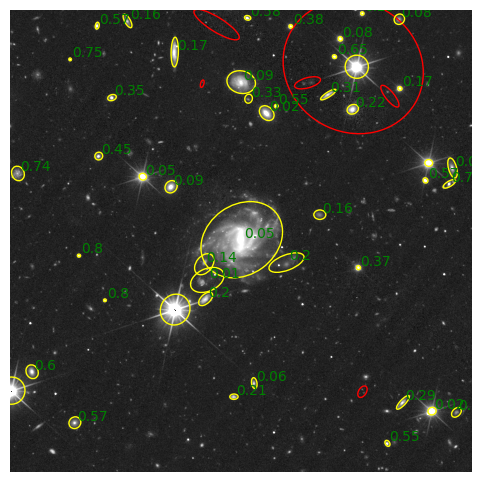

In [10]:
# plot the image with catalogue sources
fig, ax = plt.subplots()
im = ax.imshow(cutout_cat.data, cmap='gray', origin='lower', norm=ImageNormalize(cutout_cat.data, interval=PercentileInterval(99.5), stretch=AsinhStretch()))

# plot an ellipse for each object
for source in source_results_spec:
    px, py = cutout_cat.wcs.wcs_world2pix(source['right_ascension'], source['declination'], 1) 

    e = Ellipse(xy=(px, py),
                width=5*source['semimajor_axis'],
                height=5*source['semiminor_axis'],
                angle=source['position_angle']+90,
                facecolor = 'none')
    
    if type(source['spec_filename']) is np.str_:
        e.set_edgecolor('yellow')
        if type(source['phz_median']) == np.float64:
            text = Text(x=px+7, y=py+7, text=str(round(source['phz_median'], 2)), color="Green", fontsize=10)
            ax.add_artist(text)
    else:
        e.set_edgecolor('red')
    ax.add_artist(e)
    
_ = plt.axis('off')

## Step 4. Making a cutout of one source we extracted

As the next step we can make the cutouts simply with Astropy. Something to remember is that the source coordinates SEP returned are with respect to to the smaller area of the image (`small_data`). So we are going to use `small_data` to make the cutout. To make the cutout from the full original image `image_data` the coordinates have to be recalculated by adding 13300 and 12700 to each of them respectively.

In [11]:
#making and saving the cutout
cutout = Cutout2D(data=small_data, position = (sources_thr[4]['x'], sources_thr[4]['y']), size= 0.7 * u.arcmin, wcs=wcs.WCS(header))
hdu = fits.PrimaryHDU(cutout.data)
hdu.writeto(cutout_folder + "test_cutout_example2.fits", overwrite=True)

Image size: (420, 420)


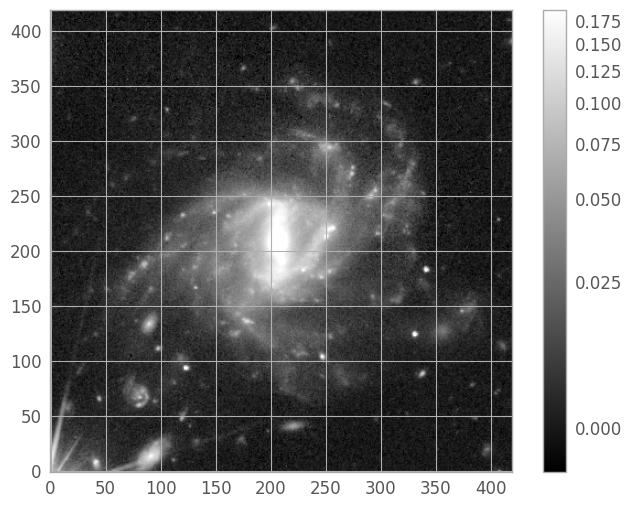

In [12]:
#taking a look at what we made
hdul = fits.open(cutout_folder + 'test_cutout_example2.fits')
image_data = hdul[0].data
print("Image size:", image_data.shape)

plt.figure()
plt.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.5), stretch=AsinhStretch()))
plt.colorbar();

### Step 5. Making a cutout of the full list of sources automatically

Next we perform the same cutout process iterating over all of the extracted sources.

In [13]:
for i, source in enumerate(sources_thr):
    print('Making cutout number:', str(i) + '/' + str(len(sources_thr)))
    cutout = Cutout2D(data=small_data, position = (source['x'], source['y']), size= 0.3 * u.arcmin, wcs=wcs.WCS(header))
        
    hdu = fits.PrimaryHDU(cutout.data)
    hdu.writeto(cutout_folder + 'extract_cut{0}.fits'.format(str(i).zfill(2)), overwrite=True)

Making cutout number: 0/20
Making cutout number: 1/20
Making cutout number: 2/20
Making cutout number: 3/20
Making cutout number: 4/20
Making cutout number: 5/20
Making cutout number: 6/20
Making cutout number: 7/20
Making cutout number: 8/20
Making cutout number: 9/20
Making cutout number: 10/20
Making cutout number: 11/20
Making cutout number: 12/20
Making cutout number: 13/20
Making cutout number: 14/20
Making cutout number: 15/20
Making cutout number: 16/20
Making cutout number: 17/20
Making cutout number: 18/20
Making cutout number: 19/20


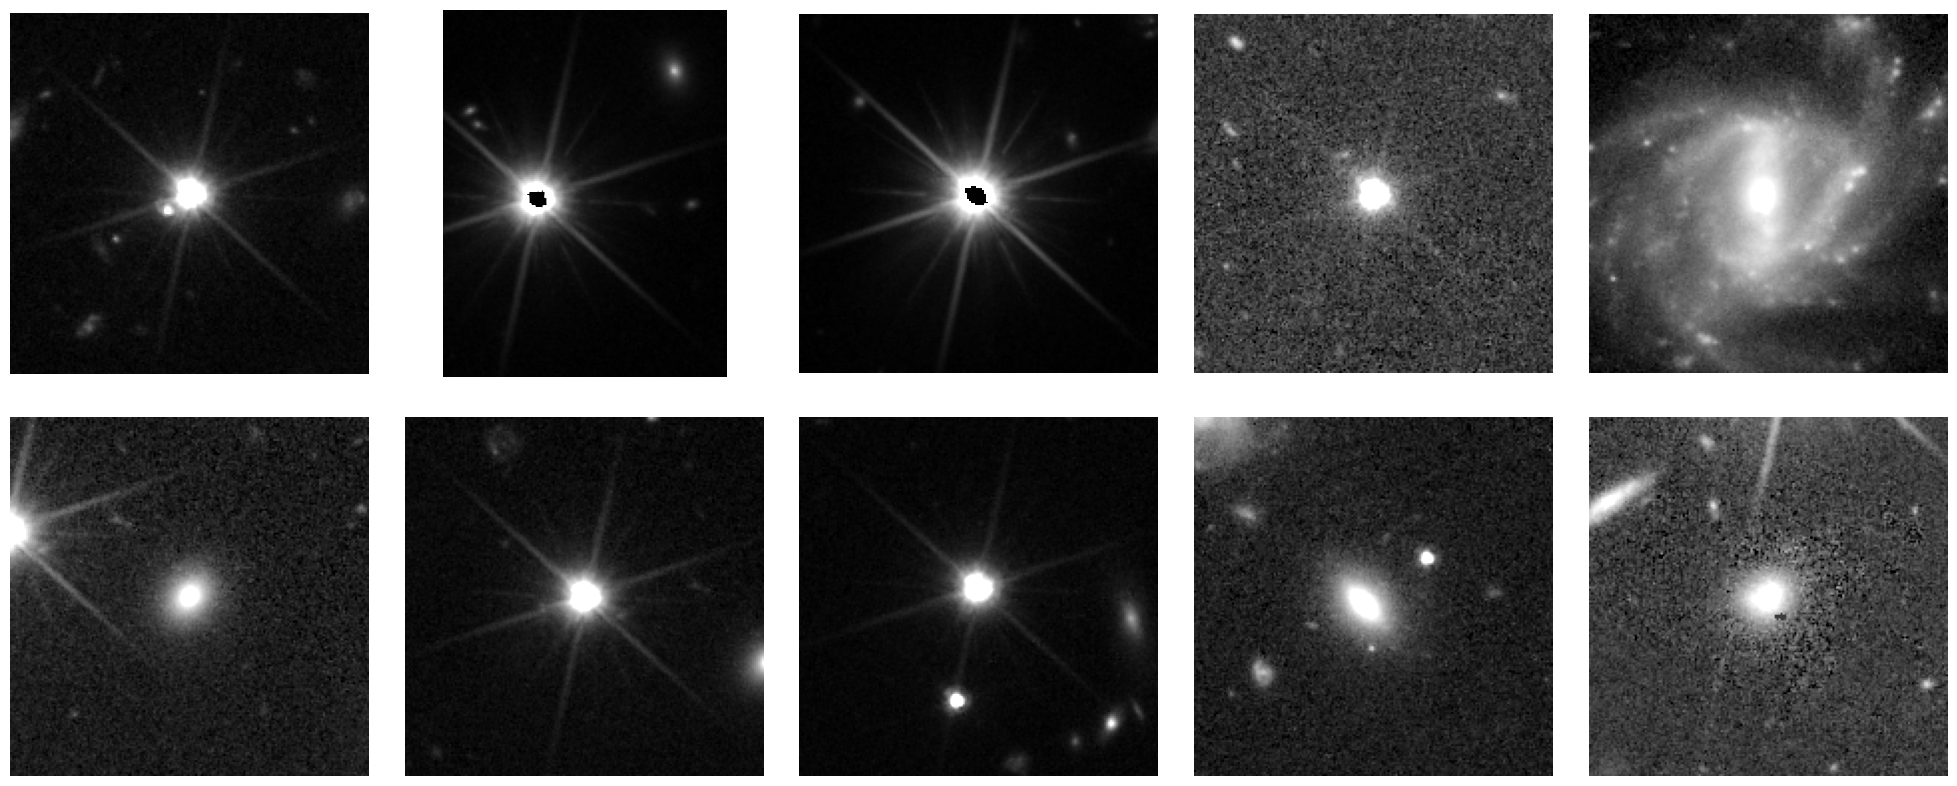

In [14]:
#showing 10 of the cutouts
files = glob.glob(cutout_folder + 'extract_cut*.fits')

_, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for ax, img_path in zip(axes.flatten(), files):
    image_data = fits.getdata(img_path, ext=0)
    ax.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.), stretch=AsinhStretch()))
    ax.axis("off")

## (Extra) Converting FITS file cutouts to jpgs

Below is one example of how to convert FITS files to jpgs and if necessary downsize them to create thumbnails.

**Creating another cutout to use**

First we make another larger cutout `convert_cutout.fits` for one of the sources we extracted before. This is the file we will be converting to jpg.

In [15]:
cutout = Cutout2D(data=small_data, position = (sources_thr[4]['x'], sources_thr[4]['y']), size= 1 * u.arcmin, wcs=wcs.WCS(header))    
hdu = fits.PrimaryHDU(cutout.data)
hdu.writeto(cutout_folder + 'convert_cutout.fits', overwrite=True)

**Converting the cutout to jpg**

Below we convert the FITS file created in the previous cell to a jpg. We start by reading in the data from the FITS file. Then we normalize the data to be in the range [0, 1] by applying an asinh stretch and clipping. We convert the data to be in range [0, 255] for the jpg image and also flip the data along the vertical axis. As the last thing we save the image with the same name but new extension `convert_cutout.jpg` 

In [16]:
# reading the FITS file
example_file = cutout_folder + 'convert_cutout.fits'
with fits.open(example_file) as hdulist:
    data = hdulist[0].data
    data_jpg = copy.deepcopy(data)

# performing clipping and stretch
transform = AsinhStretch() + PercentileInterval(99.5)
data_jpg = transform(data_jpg)*255
data_jpg = np.flipud(np.uint8(data_jpg))

# saving jpg image
image = Image.fromarray(data_jpg)
image.save(cutout_folder + os.path.basename(example_file.replace('.fits', '.jpg')))

**Comparing the created images**

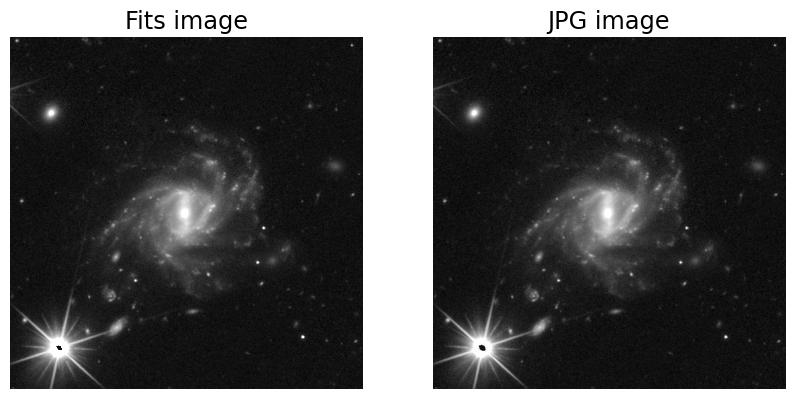

In [17]:
# getting saved FITS image
hdul = fits.open(cutout_folder + 'convert_cutout.fits')
image_data_fits = hdul[0].data

# getting saved jpg image
image_data_jpg = np.array(Image.open(cutout_folder + 'convert_cutout.jpg'))

# plotting side-by-side
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.imshow(image_data_fits, cmap='gray', origin='lower', norm=ImageNormalize(image_data_fits, interval=PercentileInterval(99.5), stretch=AsinhStretch()))  
plt.axis('off')
plt.title("Fits image") 

plt.subplot(1, 2, 2)
plt.imshow(image_data_jpg, cmap='gray')  
plt.axis('off')
plt.title("JPG image") 

plt.show()

**Downsizing the jpg if necessary**

As the next step we downsize the jpg to create a thumbnail that is half the width and height of the original. You can see the documentation for the thumbnail function here: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.thumbnail

Old img size: (600, 600)
New img size: (300, 300)


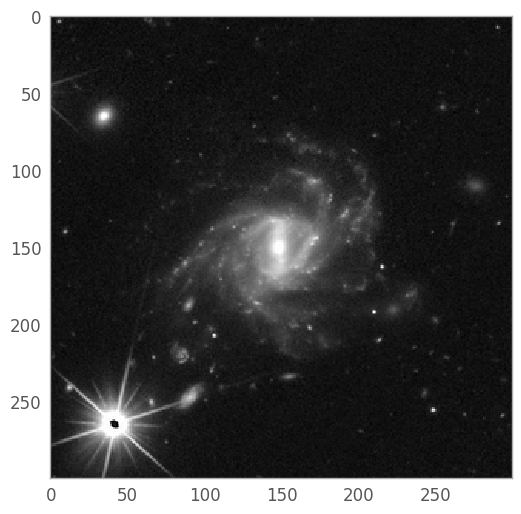

In [18]:
# downsizing the jpg
print("Old img size:", image_data_jpg.shape)
size_new = (image_data_jpg.shape[0]//2, image_data_jpg.shape[1]//2)
print("New img size:", size_new)
thumbnail = copy.deepcopy(Image.fromarray(image_data_jpg))
thumbnail.thumbnail(size_new, Image.Resampling.LANCZOS)
thumbnail.save(cutout_folder + "thumbnail.jpg")
plt.imshow(thumbnail, interpolation='nearest', cmap='gray')
plt.grid(False)
plt.show()

***

**Runnning the notebook outside of ESA Datalabs**

The current notebook was developed with the intent to use it inside ESA Datalabs, so all the filepaths point to the data volume mounted in ESA Datalabs. It is possible to modify the notebook to run outside of the platform if needed, but there are a few things to consider:

1. You need to install all the packages used in the notebook yourself
2. When trying to access any of the data, the products first need to be downloaded using Astroquery (due to the files being large this might take some time which is why using ESA Datalabs is advised)

You can download the product by using the Astroquery get_product method as shown below. You can find more information about using the function in the [Astroquery examples notebook](Astroquery.ipynb). After downloading the image you can run the rest of the notebook by substituting the Datalabs file path set in the beginning of the notebook with the one you set on you local machine.

`example_filename = 'EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits'`
`Euclid.get_product(file_name=example_filename, output_file=output_folder + 'local_file_name.fits')`